# ARIMA dan ARIMAX Pengangguran

In [1]:
import pandas as pd

In [3]:
# Load the Excel file
file_path = '../scraping\data_gti_tpt_imputed_3n.xlsx'
data = pd.read_excel(file_path)

# Extract relevant columns
years = data['Tahun']
pengangguran = data['TPT']

Melihat data pengangguran

In [4]:
pengangguran[:-1]

0      7.48
1     10.59
2      6.12
3      6.89
4      8.47
5      9.52
6      8.94
7      7.33
8      8.24
9      8.12
10     9.82
11     9.97
12     9.64
13     8.60
Name: TPT, dtype: float64

In [6]:
# Define training and testing sets
train_size = len(pengangguran) - 3
train, test = pengangguran[:train_size], pengangguran[train_size:]

In [78]:
from pmdarima import auto_arima

model = auto_arima(
    train,
    start_p=2,
    start_q=2,
    max_p=12,
    max_d=2,
    max_q=12,
    information_criterion ='oob',
    test ='adf',
    error_action='warn',
    trace=True,  
    suppress_warnings=True,
    stepwise=True,  
    n_fits=50
)

print(model.summary())

c:\Users\fezaa\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:35: UserWarning: information_criterion cannot be 'oob' with out_of_sample_size = 0. Falling back to information criterion = aic.
  warnings.warn('information_criterion cannot be \'oob\' with '


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=8327.187, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=53.671, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=51.437, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=52.437, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=53.383, Time=0.02 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.463 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   12
Model:               SARIMAX(1, 2, 0)   Log Likelihood                 -23.719
Date:                Tue, 10 Sep 2024   AIC                             51.437
Time:                        14:38:00   BIC                

In [79]:
# Forecast the next 3 data points
forecast = model.predict(n_periods=3)
forecast

12    11.291131
13    11.727392
14    12.832233
dtype: float64

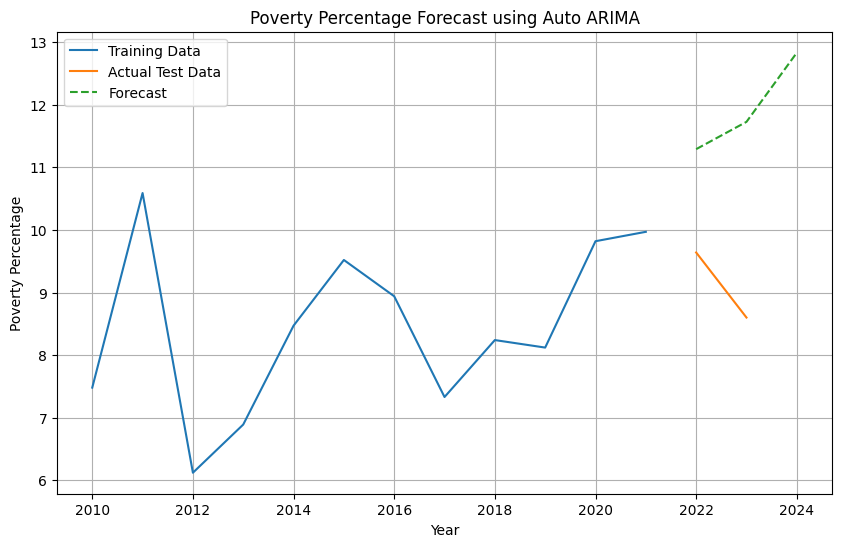

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(years[:train_size], train, label='Training Data')
plt.plot(years[train_size:], test, label='Actual Test Data')
plt.plot(years[train_size:], forecast, label='Forecast', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Poverty Percentage')
plt.title('Poverty Percentage Forecast using Auto ARIMA')
plt.legend()
plt.grid(True)
plt.show()

### Model ARCH

In [107]:
from arch import arch_model

model = arch_model(train,  vol='arch', p=1,q=1)
model

Constant Mean(constant: yes, no. of exog: 0, volatility: ARCH(p: 1), distribution: Normal distribution), id: 0x1d4e015a3d0

In [114]:
model_fit = model.fit(disp='off')

In [123]:
garch_forecast = model_fit.forecast(horizon=1)
print(garch_forecast.mean.iloc[-1, :])

h.1    8.60602
Name: 11, dtype: float64


In [96]:
print(garch_forecast)

## ARIMAX

In [43]:
# Defining the exogenous variables (excluding 'Persentase Kemiskinan' and 'Tahun')
exogenous_vars = data['Lowongan Kerja']

In [44]:
exog_train, exog_test = exogenous_vars[:train_size], exogenous_vars[train_size:]

In [56]:
# Fit the Auto ARIMAX model with exogenous variables
model_arimax = auto_arima(
    train,
    exogenous=exog_train,
    test='adf'
)

model_arimax.fit(train,exogenous=exog_train)

ARIMA(order=(1, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [57]:
# Forecast the next 3 data points
forecast_arimax = model_arimax.predict(n_periods=3, exogenous=exog_test) 

In [58]:
forecast_arimax

12    11.291131
13    11.727392
14    12.832233
dtype: float64

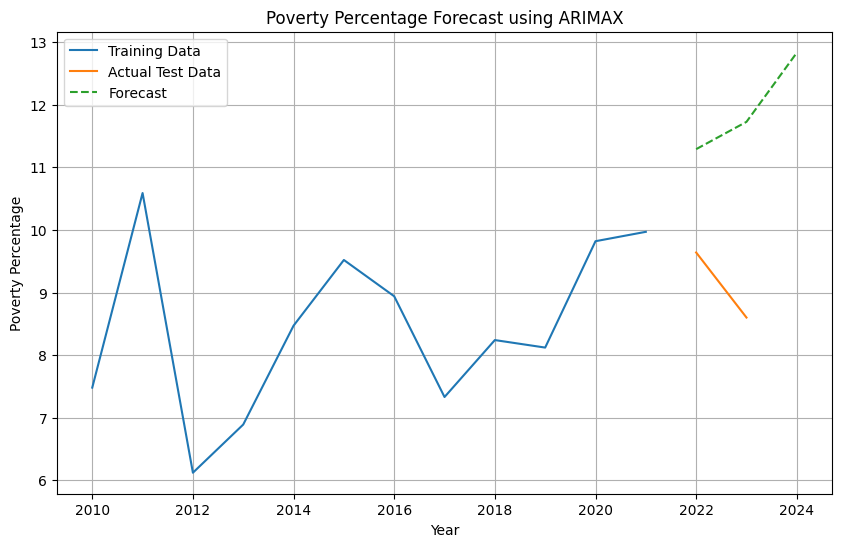

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(years[:train_size], train, label='Training Data')
plt.plot(years[train_size:], test, label='Actual Test Data')
plt.plot(years[train_size:], forecast_arimax, label='Forecast', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Poverty Percentage')
plt.title('Poverty Percentage Forecast using ARIMAX')
plt.legend()
plt.grid(True)
plt.show()

## Model

In [60]:
import joblib

# Menyimpan model
joblib.dump(model_arimax, 'model_arimax_pengangguran.joblib')

['model_arimax_pengangguran.joblib']

In [61]:
import numpy as np

def predict_arimax(query):
    # Memuat model
    model = joblib.load('model_arimax_pengangguran.joblib')
    
    # Mengubah query menjadi array numpy
    exog = np.array(query).reshape(1, -1)
    
    # Melakukan prediksi
    forecast = model.predict(n_periods=1, exogenous=exog)
    
    # Menangani berbagai kemungkinan output
    if isinstance(forecast, pd.Series):
        return forecast.iloc[0]
    elif isinstance(forecast, np.ndarray):
        return forecast[0]
    elif isinstance(forecast, (float, int)):
        return forecast
    else:
        raise ValueError(f"Unexpected forecast type: {type(forecast)}")

In [62]:
query = [59]
predict_arimax(query)

11.29113082811179